In [1]:
#@title import
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# 추가
import time
# start_time = time.time()
# print("--- %s seconds ---" % (time.time() - start_time))

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("citrus_leaves", as_supervised=True, with_info=True)
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples

test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "citrus_leaves",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/594 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/citrus_leaves/0.1.2.incomplete05BDZ4/citrus_leaves-train.tfrecord*...:   0…

Dataset citrus_leaves downloaded and prepared to /root/tensorflow_datasets/citrus_leaves/0.1.2. Subsequent calls will reuse this data.


In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [3]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.vgg16.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

**VGG16 합성곱 기반 층 만들고 동결**

In [4]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [5]:
#@title (1) data augmentation 미적용
inputs = keras.Input(shape=(224, 224, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(n_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="without_data_augmentation2.keras",
        save_best_only=True,
        monitor="val_loss")
]

In [9]:
#@title (2) data augmentation 적용
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(n_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="with_data_augmentation2.keras",
        save_best_only=True,
        monitor="val_loss")
]

In [5]:
#@title (3) Fine-tuning
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(n_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning2.keras",
        save_best_only=True,
        monitor="val_loss")
]

In [10]:
start_time = time.time()
history = model.fit(
    train_set, epochs=30, validation_data=valid_set,
    steps_per_epoch=int(0.75 * dataset_size / batch_size),
    validation_steps=int(0.15 * dataset_size / batch_size),
    callbacks=callbacks)
print(f"--- training time: {(time.time() - start_time):3f} seconds ---")

Epoch 1/30
13/13 [==============================] - 4s 181ms/step - loss: 166.9479 - accuracy: 0.5192 - val_loss: 78.7142 - val_accuracy: 0.6406
Epoch 2/30
13/13 [==============================] - 4s 301ms/step - loss: 57.3823 - accuracy: 0.6851 - val_loss: 53.4622 - val_accuracy: 0.7500
Epoch 3/30
13/13 [==============================] - 2s 169ms/step - loss: 42.1408 - accuracy: 0.7332 - val_loss: 38.7982 - val_accuracy: 0.7656
Epoch 4/30
13/13 [==============================] - 2s 160ms/step - loss: 22.1822 - accuracy: 0.8149 - val_loss: 49.6266 - val_accuracy: 0.7188
Epoch 5/30
13/13 [==============================] - 2s 154ms/step - loss: 20.6788 - accuracy: 0.8510 - val_loss: 72.3015 - val_accuracy: 0.6875
Epoch 6/30
13/13 [==============================] - 2s 151ms/step - loss: 20.4720 - accuracy: 0.8462 - val_loss: 43.1653 - val_accuracy: 0.7656
Epoch 7/30
13/13 [==============================] - 2s 170ms/step - loss: 19.2559 - accuracy: 0.8438 - val_loss: 35.3132 - val_accuracy

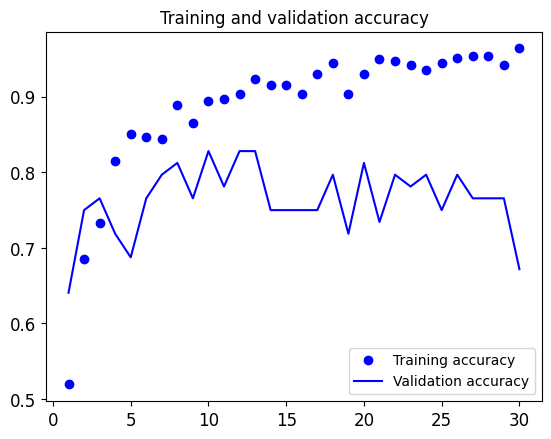

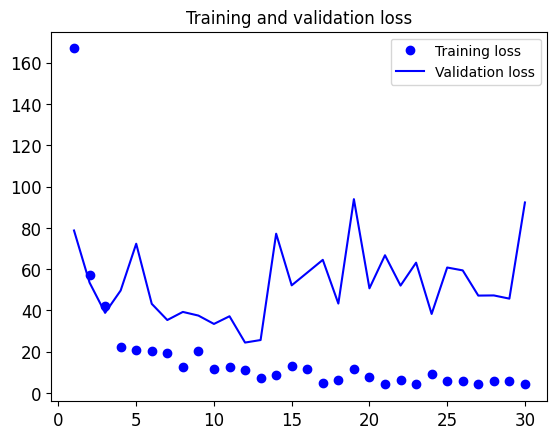

In [11]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend(loc='lower right')
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend(loc='upper right')
plt.show()

In [8]:
#@title 모델(1) 평가
print("* Evaluate on test data")
test_model = keras.models.load_model(
    "without_data_augmentation2.keras")
test_loss, test_acc = test_model.evaluate(test_set)

print("* Predict on test data")
start_time = time.time()
prediction = test_model.predict(test_set)
print(f"* preditcion_time: {(time.time() - start_time):3f} seconds")

* Evaluate on test data
2/2 [==============================] - 4s 4s/step - loss: 35.0890 - accuracy: 0.8136
* Predict on test data
2/2 [==============================] - 0s 119ms/step
* preditcion_time: 0.469240 seconds


In [12]:
#@title 모델(2) 평가
print("* Evaluate on test data")
test_model = keras.models.load_model(
    "with_data_augmentation2.keras")
test_loss, test_acc = test_model.evaluate(test_set)

print("* Predict on test data")
start_time = time.time()
prediction = test_model.predict(test_set)
print(f"* preditcion_time: {(time.time() - start_time):3f} seconds")

* Evaluate on test data
2/2 [==============================] - 1s 140ms/step - loss: 29.7841 - accuracy: 0.8644
* Predict on test data
2/2 [==============================] - 0s 123ms/step
* preditcion_time: 0.577484 seconds


In [8]:
#@title 모델(3) 평가
print("* Evaluate on test data")
test_model = keras.models.load_model(
    "fine_tuning2.keras")
test_loss, test_acc = test_model.evaluate(test_set)

print("* Predict on test data")
start_time = time.time()
prediction = test_model.predict(test_set)
print(f"* preditcion_time: {(time.time() - start_time):3f} seconds")

* Evaluate on test data
2/2 [==============================] - 5s 4s/step - loss: 2.8259 - accuracy: 0.7288
* Predict on test data
2/2 [==============================] - 0s 113ms/step
* preditcion_time: 0.479822 seconds
